<a href="https://colab.research.google.com/github/ap9055097/VideoHilightModel/blob/main/%5BHL_CLIP%5D_elephant_video_training_v0_0_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset List


In [6]:
import os

def list_video_files_walk(start_dir, video_exts=None):
    if video_exts is None:
        # Common video file extensions
        video_exts = {'.mp4', '.mkv', '.avi', '.mov', '.flv', '.wmv', '.webm'}
    video_paths = []
    annotations_data = {}
    count_bad = 0
    max_bad = 1000000000
    for root, dirs, files in os.walk(start_dir):
        if count_bad >= max_bad:
              break
        for filename in files:
            if count_bad >= max_bad:
              break
            _, ext = os.path.splitext(filename)
            if ext.lower() in video_exts:
                path = os.path.join(root, filename)
                video_id = os.path.splitext(os.path.basename(path))[0]
                # print('video_id', video_id)
                # print('path', path)
                video_paths.append(path)
                if "/bad/" in path:
                  annotations_data[video_id] = []
                  count_bad += 1
    return video_paths, annotations_data


directory_to_search = "/content/drive/MyDrive/elephant_clip/train_augmented"
train_video_paths, train_annotations_data = list_video_files_walk(directory_to_search)
# train_video_paths, train_annotations_data

In [7]:
import random

goods = []
bads = []
for path in train_video_paths:
    if "/bad/" in path:
        bads.append(path)
    else:
        goods.append(path)

random.seed(4)
random.shuffle(goods)
random.shuffle(bads)

len(goods), len(bads)

(100, 240)

In [8]:
num_train_samples = 10
train_video_paths = goods[:num_train_samples] + bads[:num_train_samples]
len(train_video_paths)

20

In [9]:
directory_to_search = "/content/drive/MyDrive/elephant_clip/val"
val_video_paths, val_annotations_data = list_video_files_walk(directory_to_search)
val_video_paths, val_annotations_data

(['/content/drive/MyDrive/elephant_clip/val/good/Copy of 3QbFg0aff2Q.webm',
  '/content/drive/MyDrive/elephant_clip/val/bad/GR7tNq9l4R8.webm',
  '/content/drive/MyDrive/elephant_clip/val/bad/VcTaIc98_eE.webm'],
 {'GR7tNq9l4R8': [], 'VcTaIc98_eE': []})

# install Dependencies

In [2]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8ouih_4q
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8ouih_4q
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s

In [3]:
!pip install torch-tensorrt

# Setup Model

In [13]:
# 0. Import Libraries
import torch
import clip
from PIL import Image
import cv2
import os
import numpy as np
from tqdm import tqdm
# Potentially import from the HL-CLIP repository or your adapted versions
# from hl_clip_model import HLCLIP # Assuming you create/adapt this

ValueError: module functions cannot set METH_CLASS or METH_STATIC

In [10]:
import torch
import cv2 # OpenCV for video processing
from PIL import Image # For image manipulation
import os # For path manipulation
# numpy might be implicitly needed by cv2 or for other operations, good to have.
# import numpy as np

class ElephantHighlightDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset for loading video clips and their highlight annotations.

    If a video_id is not present in the annotations, the entire video is
    considered a highlight.
    If a video_id is present and its annotation is an empty list [],
    it means the video is annotated but has no specific highlight segments.
    """
    ENTIRE_VIDEO_IS_HIGHLIGHT_MARKER = "ENTIRE_VIDEO_HIGHLIGHT"  # Class attribute marker

    def __init__(self, video_paths, annotations, transform=None, frames_per_clip=16, stride=1):
        """
        Args:
            video_paths (list): List of paths to video files.
            annotations (dict or None): A dictionary mapping video_id (str, typically filename without extension)
                                        to a list of [start_sec, end_sec] highlight segments.
                                        If None, or if a video_id is missing, the entire video is a highlight.
                                        An empty list [] for a video_id means that video has no highlights.
            transform (callable, optional): A function/transform to apply to each frame (PIL Image).
                                            Expected to return a tensor.
            frames_per_clip (int): The number of frames to extract per clip.
            stride (int): The step size (in frames) to sample frames from the video.
        """
        self.video_paths = video_paths
        # Handle cases where annotations might be None by treating it as an empty dict
        self.annotations = annotations if annotations is not None else {}
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.stride = stride

        if self.stride <= 0:
            raise ValueError("Stride must be a positive integer.")

        self.clips = self._create_clips()

    def _create_clips(self):
        """
        Prepares a list of clips to be loaded. Each "clip" currently corresponds
        to one video, from which `frames_per_clip` frames will be extracted.
        Determines if the whole video is a highlight based on annotations.
        """
        clips_data = []
        for video_path in self.video_paths:
            if not os.path.exists(video_path):
                print(f"Warning: Video path not found, skipping: {video_path}")
                continue

            video_id = os.path.splitext(os.path.basename(video_path))[0]

            if video_id in self.annotations:
                # Annotation exists for this video
                highlight_segments_info = self.annotations[video_id]
                # If it's an empty list [], it explicitly means no highlights for this (annotated) video.
            else:
                # No annotation provided for this video_id, so the entire video is a highlight.
                highlight_segments_info = self.ENTIRE_VIDEO_IS_HIGHLIGHT_MARKER

            clips_data.append({
                "video_path": video_path,
                "video_id": video_id,
                "highlight_segments_info": highlight_segments_info
            })
        return clips_data

    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        """
        Retrieves a clip (sequence of frames) and its corresponding frame-level labels.
        """
        clip_info = self.clips[idx]
        video_path = clip_info["video_path"]
        highlight_segments_info = clip_info["highlight_segments_info"]

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Warning: Could not open video {video_path}. Skipping.")
            return torch.empty(0), torch.empty(0)

        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if fps <= 0 or total_frames_in_video == 0:
            print(f"Warning: FPS ({fps:.2f}) or total frames ({total_frames_in_video}) is invalid for video {video_path}. Skipping.")
            cap.release()
            return torch.empty(0), torch.empty(0)

        frames = []
        frame_indices = [] # Stores the original frame index in the video

        current_frames_extracted = 0
        # Iterate through video frames with the specified stride
        for frame_num in range(0, total_frames_in_video, self.stride):
            if current_frames_extracted >= self.frames_per_clip:
                break # Reached the desired number of frames for the clip

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if not ret:
                # Could not read frame (e.g., end of video sooner than expected or corruption)
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)

            processed_frame = pil_image # Default if no transform
            if self.transform:
                processed_frame = self.transform(pil_image)

            frames.append(processed_frame)
            frame_indices.append(frame_num)
            current_frames_extracted += 1

        cap.release()

        if not frames:
            # No frames were extracted (e.g., video was shorter than first stride, or frames_per_clip is 0)
            # print(f"Warning: No frames extracted for {video_path}.") # Can be noisy if expected for very short videos
            return torch.empty(0), torch.empty(0)

        # Generate frame-level labels
        frame_labels = torch.zeros(len(frames), dtype=torch.float32)

        if highlight_segments_info == self.ENTIRE_VIDEO_IS_HIGHLIGHT_MARKER:
            # Entire video is a highlight, so all extracted frames are highlights
            frame_labels = torch.ones(len(frames), dtype=torch.float32)
        elif isinstance(highlight_segments_info, list):
            # Specific highlight segments are provided (or an empty list for no highlights)
            if not highlight_segments_info: # Empty list means no highlights
                pass # frame_labels remain all zeros
            else:
                for i, sampled_frame_original_idx in enumerate(frame_indices):
                    frame_time_sec = sampled_frame_original_idx / fps
                    for start_sec, end_sec in highlight_segments_info:
                        if start_sec <= frame_time_sec <= end_sec:
                            frame_labels[i] = 1.0
                            break # This frame is a highlight, move to the next frame
        else:
            # This case should ideally not be reached if _create_clips is correct
            print(f"Warning: Unexpected highlight_segments_info '{highlight_segments_info}' for {video_path}. Defaulting to no highlights.")
            # frame_labels remain all zeros

        # Stack frames into a tensor
        # This assumes that `self.transform` (if provided) converts PIL Images to PyTorch Tensors
        # and ensures they are of the same size. If `self.transform` is None or doesn't
        # produce tensors, torch.stack will fail.
        try:
            frames_tensor = torch.stack(frames)
        except TypeError as e:
            # Common if 'frames' contains PIL Images (i.e., self.transform was None or didn't convert to tensor)
            # For models like CLIP, self.transform (the preprocess function) *does* return a tensor.
            print(f"TypeError during torch.stack for {video_path}: {e}. "
                  f"Ensure self.transform converts images to tensors of uniform shape.")
            # Attempt a fallback basic conversion if they are all PIL Images
            if all(isinstance(f, Image.Image) for f in frames):
                try:
                    import torchvision.transforms.functional as TF
                    tensor_frames = [TF.to_tensor(f) for f in frames]
                    frames_tensor = torch.stack(tensor_frames)
                    print(f"Info: Fallback - Converted PIL Images to Tensors for {video_path}. "
                          "Please ensure transform handles this properly for consistency.")
                except Exception as conv_e:
                    print(f"Error: Fallback conversion to tensor failed for {video_path}: {conv_e}")
                    return torch.empty(0), torch.empty(0)
            else: # Some other TypeError, or mixed types
                return torch.empty(0), torch.empty(0)
        except RuntimeError as e: # Typically size mismatch if tensors are not uniform
            print(f"RuntimeError during torch.stack for {video_path}: {e}. "
                  f"Ensure self.transform produces tensors of uniform shape.")
            return torch.empty(0), torch.empty(0)

        return frames_tensor, frame_labels

In [11]:
# Define HLCLIPModel class here (using the version that calls self.clip_visual_encoder(x_frames_flat))
# (Make sure this is the version from the previous successful correction for the AttributeError)
class HLCLIPModel(torch.nn.Module):
    def __init__(self, clip_visual_encoder, num_transformer_layers_to_unfreeze=2, hidden_dim=512, num_classes=1):
        super().__init__()
        self.clip_visual_encoder = clip_visual_encoder # This is original_clip_model.visual

        # Freeze most of CLIP's visual encoder
        for param in self.clip_visual_encoder.parameters():
            param.requires_grad = False

        # Unfreeze last N layers of the visual transformer
        if hasattr(self.clip_visual_encoder, 'transformer') and hasattr(self.clip_visual_encoder.transformer, 'resblocks'): # For ViT models
            if self.clip_visual_encoder.transformer.resblocks is not None:
                try:
                    total_layers = len(self.clip_visual_encoder.transformer.resblocks)
                    for i in range(max(0, total_layers - num_transformer_layers_to_unfreeze), total_layers):
                        for param in self.clip_visual_encoder.transformer.resblocks[i].parameters():
                            param.requires_grad = True
                except TypeError:
                    print("Warning: Could not unfreeze transformer resblocks. Check model structure.")
            else:
                print("Warning: self.clip_visual_encoder.transformer.resblocks is None. Cannot unfreeze.")
        elif hasattr(self.clip_visual_encoder, 'layer4'): # Example for ResNet-based CLIP (e.g., layer4)
            # Unfreeze layer4 and the attnpool
            if hasattr(self.clip_visual_encoder, 'attnpool'):
                 for param in self.clip_visual_encoder.attnpool.parameters():
                        param.requires_grad = True
            for param in self.clip_visual_encoder.layer4.parameters(): # Unfreeze layer4
                param.requires_grad = True
        else:
            print("Warning: Could not determine how to unfreeze layers for the provided clip_visual_encoder.")

        visual_output_dim = self.clip_visual_encoder.output_dim
        self.fc = torch.nn.Linear(visual_output_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, x_frames): # x_frames: (batch_size, num_frames, C, H, W)
        batch_size, num_frames, C, H, W = x_frames.shape

        # Ensure x_frames is on the same device and dtype as the model expects for the visual encoder.
        # The input x_frames should already be float32 from preprocess and moved to device in training loop.
        x_frames_flat = x_frames.view(batch_size * num_frames, C, H, W)

        # Debug: Check dtypes right before the problematic call
        # if hasattr(self.clip_visual_encoder, 'conv1'): # For ViT
        #     print(f"DEBUG HLCLIPModel forward: x_frames_flat dtype: {x_frames_flat.dtype}, "
        #           f"conv1 weight dtype: {self.clip_visual_encoder.conv1.weight.dtype}")
        # elif hasattr(self.clip_visual_encoder, 'stem') and len(self.clip_visual_encoder.stem) > 0: # For ResNet
        #      print(f"DEBUG HLCLIPModel forward: x_frames_flat dtype: {x_frames_flat.dtype}, "
        #       f"stem[0] weight dtype: {self.clip_visual_encoder.stem[0].weight.dtype}")


        frame_features = self.clip_visual_encoder(x_frames_flat)

        # Ensure features are float32 before passing to custom FC layers
        frame_features = frame_features.to(torch.float32)

        frame_features = frame_features.view(batch_size, num_frames, -1)
        out = self.fc(frame_features)
        out = self.relu(out)
        highlight_scores = self.output_layer(out)
        return torch.sigmoid(highlight_scores.squeeze(-1))

In [ ]:
# 3. Video Augmentation (conceptual)
#    - Implemented within the Dataset's __getitem__ or via torchvision.transforms for frames

# Load Model

In [12]:
# Define collate_fn here (ensure it's the latest version)
# ... (your collate_fn code)
def collate_fn(batch):
    batch = [b for b in batch if b is not None and b[0].nelement() > 0 and b[1].nelement() > 0]
    if not batch:
        return None, None
    frames_list, labels_list = zip(*batch)
    padded_frames = torch.nn.utils.rnn.pad_sequence(frames_list, batch_first=True, padding_value=0.0)
    padded_labels = torch.nn.utils.rnn.pad_sequence(labels_list, batch_first=True, padding_value=0.0)
    return padded_frames, padded_labels


# # --- Main Setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model_name = "ViT-B/32"

print(f"Loading CLIP model {clip_model_name} to CPU...")
# 1. Load to CPU
original_clip_model, preprocess = clip.load(clip_model_name, device="cpu", jit=False)
print(f"CLIP model loaded to CPU. Initial dtype: {next(original_clip_model.parameters()).dtype}")

# 2. Convert to float32 while on CPU
original_clip_model = original_clip_model.float()
print(f"CLIP model converted to float32 on CPU. New dtype: {next(original_clip_model.parameters()).dtype}")

# 3. Move the float32 model to the target device
original_clip_model = original_clip_model.to(device)
print(f"CLIP model moved to {device}. Dtype on {device}: {next(original_clip_model.parameters()).dtype}")

# Extract the visual part (which should now be float32 and on the correct device)
visual_encoder_component = original_clip_model.visual

# Debug: Check the dtype of a specific layer in the visual_encoder_component
if hasattr(visual_encoder_component, 'conv1'): # For ViT
    print(f"Visual encoder (ViT) conv1.weight dtype: {visual_encoder_component.conv1.weight.dtype}")
elif hasattr(visual_encoder_component, 'stem') and isinstance(visual_encoder_component.stem[0], torch.nn.Conv2d): # For ResNet
    print(f"Visual encoder (ResNet) stem[0].weight dtype: {visual_encoder_component.stem[0].weight.dtype}")


# 4. Instantiate your HLCLIPModel
model = HLCLIPModel(visual_encoder_component, num_transformer_layers_to_unfreeze=2).to(device)
# The .to(device) on HLCLIPModel should not change dtypes if its components are already correct.

print(f"HLCLIPModel instantiated on {device}.")
# Debug: Check dtypes within the instantiated HLCLIPModel
if hasattr(model.clip_visual_encoder, 'conv1'): # For ViT
    print(f"  HLCLIPModel's visual_encoder.conv1.weight dtype: {model.clip_visual_encoder.conv1.weight.dtype}")
elif hasattr(model.clip_visual_encoder, 'stem') and isinstance(model.clip_visual_encoder.stem[0], torch.nn.Conv2d): # For ResNet
     print(f"  HLCLIPModel's visual_encoder.stem[0].weight dtype: {model.clip_visual_encoder.stem[0].weight.dtype}")
print(f"  HLCLIPModel's fc.weight dtype: {model.fc.weight.dtype}") # Custom FC layers should be float32 by default

Loading CLIP model ViT-B/32 to CPU...


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 45.2MiB/s]


CLIP model loaded to CPU. Initial dtype: torch.float32
CLIP model converted to float32 on CPU. New dtype: torch.float32
CLIP model moved to cuda. Dtype on cuda: torch.float32
Visual encoder (ViT) conv1.weight dtype: torch.float32
HLCLIPModel instantiated on cuda.
  HLCLIPModel's visual_encoder.conv1.weight dtype: torch.float32
  HLCLIPModel's fc.weight dtype: torch.float32


# Prepare Dataset

In [13]:
#  Dummy data and DataLoader (ensure ElephantHighlightDataset and video creation is correct)
# ... (your dummy data setup as in the previous response, ensure videos are valid and long enough)
# dummy_video_paths = ["dummy_video1.mp4", "dummy_video2.mp4"] # Create small dummy mp4 files for testing
# dummy_annotations = {"dummy_video1": [[5, 10]], "dummy_video2": [[2, 6], [15, 20]]}

# train_video_paths
# train_annotations_data

for p in train_video_paths:
    if not os.path.exists(p):
        try:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out_dummy = cv2.VideoWriter(p, fourcc, 30, (224, 224))
            for _ in range(30 * 5): # 5 seconds of video
                frame = np.zeros((224, 224, 3), dtype=np.uint8)
                out_dummy.write(frame)
            out_dummy.release()
        except Exception as e: print(f"Error creating dummy video {p}: {e}")

train_dataset = ElephantHighlightDataset(train_video_paths, train_annotations_data, transform=preprocess, frames_per_clip=32, stride=15)
if len(train_dataset) == 0:
    raise ValueError("Train dataset is empty! Check video paths, annotations, or dataset creation logic.")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [14]:


for p in val_video_paths:
    if not os.path.exists(p):
        try:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out_dummy = cv2.VideoWriter(p, fourcc, 30, (224, 224))
            for _ in range(30 * 5): # 5 seconds of video
                frame = np.zeros((224, 224, 3), dtype=np.uint8)
                out_dummy.write(frame)
            out_dummy.release()
        except Exception as e: print(f"Error creating dummy video {p}: {e}")

validation_dataset = ElephantHighlightDataset(val_video_paths, val_annotations_data, transform=preprocess, frames_per_clip=32, stride=15)
if len(train_dataset) == 0:
    raise ValueError("Train dataset is empty! Check video paths, annotations, or dataset creation logic.")
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

if len(validation_dataset) == 0:
    print("Warning: Validation dataset is empty! Check paths or dataset logic.")
    # Handle this case, perhaps by skipping validation or raising an error earlier
    validation_loader = None
else:
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=2, # Adjust batch size as needed
        shuffle=False, # No need to shuffle for validation
        collate_fn=collate_fn # Use the same collate_fn
    )

In [15]:
len(train_dataset), len(validation_dataset)

(20, 3)

# Metrics

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np # Ensure numpy is imported

def calculate_frame_metrics(all_preds_flat, all_labels_flat, threshold=0.5):
    """
    Calculates frame-level precision, recall, and F1-score.
    Args:
        all_preds_flat (np.array): 1D array of predicted probabilities.
        all_labels_flat (np.array): 1D array of ground truth labels (0 or 1).
        threshold (float): Threshold to convert probabilities to binary predictions.
    Returns:
        dict: Dictionary containing precision, recall, f1, and confusion matrix.
    """
    if len(all_preds_flat) == 0 or len(all_labels_flat) == 0:
        return {"precision": 0, "recall": 0, "f1": 0, "tn": 0, "fp": 0, "fn": 0, "tp": 0, "accuracy": 0}

    binary_preds = (all_preds_flat >= threshold).astype(int)

    precision = precision_score(all_labels_flat, binary_preds, zero_division=0)
    recall = recall_score(all_labels_flat, binary_preds, zero_division=0)
    f1 = f1_score(all_labels_flat, binary_preds, zero_division=0)

    # Confusion matrix: tn, fp, fn, tp
    # Ensure labels=[0, 1] to handle cases where one class might be missing in a small batch/dataset
    # For a large enough dataset, this is less of an issue.
    # If binary_preds or all_labels_flat only contain one class, confusion_matrix might return a 1x1 matrix.
    unique_labels = np.unique(np.concatenate((all_labels_flat, binary_preds)))
    if len(unique_labels) == 1: # Only one class present in both true and pred
        if unique_labels[0] == 0: # Only negatives
            tn = len(all_labels_flat)
            fp, fn, tp = 0,0,0
        else: # Only positives
            tp = len(all_labels_flat)
            tn, fp, fn = 0,0,0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    else: # Both classes are potentially present
        cm = confusion_matrix(all_labels_flat, binary_preds, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0


    return {"precision": precision, "recall": recall, "f1": f1, "tn": tn, "fp": fp, "fn": fn, "tp": tp, "accuracy": accuracy}

In [23]:
def validate_model(model, val_loader, criterion, device, threshold=0.5):
    """
    Validates the model on the validation set.
    Args:
        model (torch.nn.Module): The model to validate.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device to run validation on.
        threshold (float): Threshold for converting probabilities to binary predictions.
    Returns:
        tuple: (average_validation_loss, metrics_dict)
    """
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    all_predictions_list = []
    all_labels_list = []
    batches_processed = 0

    with torch.no_grad():  # Disable gradient calculations
        for batch_idx, batch_data in enumerate(tqdm(val_loader, desc="Validating")):
            if batch_data is None or batch_data[0] is None:
                print(f"Skipping empty or invalid validation batch {batch_idx} from collate_fn.")
                continue

            video_frames, labels = batch_data

            if video_frames.nelement() == 0:
                print(f"Skipping validation batch {batch_idx} due to empty video_frames tensor.")
                continue

            video_frames = video_frames.to(device)
            labels = labels.to(device) # Shape: (batch_size, num_frames)

            predictions = model(video_frames) # Shape: (batch_size, num_frames)

            min_len = min(predictions.shape[1], labels.shape[1])
            if min_len == 0:
                 print(f"Skipping validation batch {batch_idx} due to min_len=0.")
                 continue
            predictions_aligned = predictions[:, :min_len]
            labels_aligned = labels[:, :min_len]

            if predictions_aligned.nelement() == 0 or labels_aligned.nelement() == 0:
                print(f"Skipping validation batch {batch_idx} due to zero elements after alignment.")
                continue

            loss = criterion(predictions_aligned, labels_aligned)
            total_val_loss += loss.item()
            batches_processed += 1

            # Store predictions and labels for overall metric calculation
            all_predictions_list.append(predictions_aligned.cpu().numpy().flatten())
            all_labels_list.append(labels_aligned.cpu().numpy().flatten())

    if batches_processed == 0:
        print("No batches were processed during validation. Returning zero metrics.")
        return 0, {"precision": 0, "recall": 0, "f1": 0, "tn": 0, "fp": 0, "fn": 0, "tp": 0, "accuracy": 0}

    avg_val_loss = total_val_loss / batches_processed

    # Concatenate all predictions and labels
    all_preds_flat = np.concatenate(all_predictions_list)
    all_labels_flat = np.concatenate(all_labels_list)

    # print('all_preds_flat', all_preds_flat)
    # print('all_labels_flat', all_labels_flat)

    metrics = calculate_frame_metrics(all_preds_flat, all_labels_flat, threshold)

    return avg_val_loss, metrics

# Training

In [ ]:
# (Your existing training setup: model, optimizer, criterion, train_loader, etc.)
# ... (HLCLIPModel, ElephantHighlightDataset, collate_fn, preprocess, device etc. need to be defined)
# ... (Load CLIP, convert to float32, instantiate HLCLIPModel, optimizer, criterion as before)
# ... (Create dummy train/val videos, train_dataset, train_loader, validation_dataset, validation_loader as shown above)

# Optimizer and Loss
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
criterion = torch.nn.BCELoss()


print("Starting training and validation loop...")
num_epochs = 4 # Example
best_val_f1 = -1 # To save the best model based on F1-score, for example

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    total_train_loss = 0
    train_batches_processed = 0

    for batch_idx, batch_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")):
        # ... (your existing training batch logic) ...
        if batch_data is None or batch_data[0] is None:
            print(f"Skipping empty or invalid training batch {batch_idx} from collate_fn.")
            continue
        video_frames, labels = batch_data
        if video_frames.nelement() == 0:
            print(f"Skipping training batch {batch_idx} due to empty video_frames tensor.")
            continue

        video_frames = video_frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(video_frames)

        min_len = min(predictions.shape[1], labels.shape[1])
        if min_len == 0:
            print(f"Skipping training batch {batch_idx} due to min_len=0.")
            continue
        predictions_aligned = predictions[:, :min_len]
        labels_aligned = labels[:, :min_len]

        if predictions_aligned.nelement() == 0 or labels_aligned.nelement() == 0:
            print(f"Skipping training batch {batch_idx} due to zero elements post-alignment.")
            continue

        try:
            loss = criterion(predictions_aligned, labels_aligned)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            train_batches_processed +=1
        except RuntimeError as e:
            print(f"Runtime error during training loss/backward for batch {batch_idx}: {e}")
            continue

    avg_train_loss = total_train_loss / train_batches_processed if train_batches_processed > 0 else 0
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

    # --- Validation Step ---
    if validation_loader: # Only run validation if the loader was successfully created
        avg_val_loss, val_metrics = validate_model(model, validation_loader, criterion, device, threshold=0.5)
        print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")
        print(f"Epoch {epoch+1} - Validation Metrics (Frame-Level):")
        print(f"  Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, F1-Score: {val_metrics['f1']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"  TN: {val_metrics['tn']}, FP: {val_metrics['fp']}, FN: {val_metrics['fn']}, TP: {val_metrics['tp']}")

        # Example: Save the model if validation F1 improves
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            torch.save(model.state_dict(), "best_hlclip_model.pth")
            print(f"New best validation F1: {best_val_f1:.4f}. Model saved to best_hlclip_model.pth")
    else:
        print("Skipping validation as validation_loader is not available.")

print("Training and validation finished.")

# To load the best model later:
# model.load_state_dict(torch.load("best_hlclip_model.pth"))
# model.eval()

Starting training and validation loop...


Epoch 1/4 [Training]: 100%|██████████| 10/10 [04:02<00:00, 24.29s/it]


Epoch 1 - Training Loss: 0.6763


Validating: 100%|██████████| 2/2 [00:48<00:00, 24.48s/it]


all_preds_flat [0.5225878  0.54144233 0.5433463  0.5410959  0.53662497 0.49992406
 0.559193   0.5454702  0.5353346  0.54724556 0.5501838  0.5347098
 0.5460341  0.5324557  0.5362321  0.5041454  0.5348347  0.519287
 0.51749    0.5178836  0.51788694 0.51351464 0.5105569  0.5072191
 0.5178161  0.5045232  0.5186914  0.51890737 0.5224287  0.5324302
 0.48861927 0.48861927 0.49503893 0.5002784  0.49716362 0.50254893
 0.4864476  0.48269314 0.51476324 0.5098843  0.5060159  0.5097177
 0.49808812 0.4823548  0.50461835 0.5107068  0.50905305 0.5004153
 0.51755697 0.50610894 0.49011618 0.5092763  0.50397706 0.5044606
 0.51187783 0.49146077 0.5078479  0.49737632 0.49865732 0.48125315
 0.50287664 0.4976621  0.51336175 0.50813884 0.5458212  0.52729243
 0.53914726 0.5425164  0.5213971  0.53712195 0.53189474 0.5348592
 0.5402713  0.537704   0.53379744 0.5518986  0.5391309  0.543879
 0.55345356 0.55518687 0.540268   0.553546   0.5417495  0.5445411
 0.5455856  0.54110503 0.5509486  0.5522598  0.5466699  0.5

Epoch 2/4 [Training]: 100%|██████████| 10/10 [03:57<00:00, 23.76s/it]


Epoch 2 - Training Loss: 0.5879


Validating: 100%|██████████| 2/2 [00:50<00:00, 25.30s/it]


all_preds_flat [0.49229982 0.5300647  0.53448796 0.5269284  0.52833533 0.46934995
 0.5693245  0.54603404 0.5296376  0.55300194 0.55835193 0.5373898
 0.5549976  0.5307724  0.53981495 0.48922786 0.5395259  0.5156486
 0.5092648  0.509992   0.5047577  0.49144706 0.48359683 0.48291287
 0.5010469  0.48271745 0.499987   0.49753904 0.5142505  0.5347646
 0.46783647 0.46783647 0.4630325  0.45889953 0.4586705  0.4672962
 0.45262936 0.4451465  0.48465666 0.48247823 0.46731573 0.47493693
 0.45775962 0.44172227 0.47308773 0.48335359 0.48338193 0.47192562
 0.48782918 0.47792688 0.4460721  0.46874395 0.46568018 0.4648175
 0.47230724 0.45310527 0.46675238 0.46869168 0.45746106 0.43710217
 0.4671564  0.45720315 0.47472784 0.46913737 0.55543625 0.52627134
 0.54053456 0.55532515 0.52102447 0.541468   0.53355527 0.5395914
 0.5489915  0.5447748  0.5395002  0.56386584 0.54514015 0.5539426
 0.5692381  0.56909066 0.547701   0.56594175 0.5565082  0.5577815
 0.5580247  0.5584157  0.5684799  0.57370746 0.5603002 

Epoch 3/4 [Training]: 100%|██████████| 10/10 [04:01<00:00, 24.11s/it]


Epoch 3 - Training Loss: 0.5030


Validating: 100%|██████████| 2/2 [00:50<00:00, 25.48s/it]


all_preds_flat [0.48368272 0.5574484  0.5646968  0.5519394  0.5658476  0.4642303
 0.62228924 0.5918364  0.56605476 0.6088873  0.6131705  0.5815168
 0.60929495 0.5755058  0.59179986 0.50738364 0.5892433  0.5506633
 0.54183006 0.5418832  0.52110225 0.4985219  0.47877932 0.48107255
 0.51604664 0.48508927 0.5153759  0.5107049  0.5439264  0.58580285
 0.45771676 0.45771676 0.4580974  0.4454532  0.45549974 0.45926523
 0.43539637 0.42356423 0.4897215  0.49396044 0.45619145 0.47368452
 0.4440367  0.4230054  0.47139046 0.48580423 0.48680198 0.48150086
 0.49327692 0.4877202  0.42804542 0.46086726 0.45439816 0.45859176
 0.46789047 0.4427486  0.45802346 0.47351313 0.44701073 0.41527146
 0.45452726 0.4436142  0.46248385 0.45804015 0.6198452  0.5757568
 0.59267724 0.62432015 0.572741   0.59974176 0.5887372  0.59470767
 0.6095875  0.6072572  0.6011942  0.62911725 0.6057438  0.6180363
 0.6355566  0.6311656  0.6035733  0.6283551  0.62434983 0.6210126
 0.61938596 0.6230009  0.63155407 0.6398124  0.625444

Epoch 4/4 [Training]: 100%|██████████| 10/10 [04:00<00:00, 24.05s/it]


Epoch 4 - Training Loss: 0.4217


Validating: 100%|██████████| 2/2 [00:50<00:00, 25.10s/it]

all_preds_flat [0.44192407 0.5336282  0.5463551  0.52427584 0.54107386 0.40625402
 0.6433243  0.59398293 0.5491024  0.6215835  0.6329871  0.5856069
 0.62324435 0.56889945 0.59591806 0.47876215 0.5999918  0.54079115
 0.5255064  0.5189118  0.4885289  0.458691   0.43948573 0.44201124
 0.48507357 0.44857246 0.48176965 0.47468206 0.520445   0.5749314
 0.4398734  0.4398734  0.41159803 0.38812122 0.38435784 0.3986417
 0.39369828 0.37729093 0.43368763 0.44343388 0.39630863 0.409026
 0.37910715 0.36814222 0.40856427 0.4363653  0.4361596  0.42703235
 0.443478   0.4359329  0.36880374 0.39190745 0.39308414 0.3895821
 0.3931911  0.380482   0.38573343 0.4123327  0.37736905 0.3611032
 0.4031703  0.38353035 0.40637854 0.39925623 0.64753777 0.56401986
 0.5786837  0.6502418  0.57666546 0.6112771  0.59065074 0.6054918
 0.63216174 0.620038   0.60712534 0.6488185  0.61732006 0.6370628
 0.67048395 0.6629286  0.6250067  0.65696317 0.65815955 0.65083086
 0.6496995  0.65892935 0.66407377 0.6819296  0.6586268  

# Predict

In [45]:
# 6. Production (Inference)
def predict_highlights(video_path, model, transform, device, frames_per_clip=100, stride=5, threshold=0.5):
    model.eval()
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    extracted_frames_pil = []
    frame_indices = []

    for i in range(0, total_frames_video, stride):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        extracted_frames_pil.append(pil_image)
        frame_indices.append(i)
    cap.release()

    if not extracted_frames_pil:
        return []

    all_highlight_scores = []
    with torch.no_grad():
        # Process in chunks if video is too long for memory
        for i in range(0, len(extracted_frames_pil), frames_per_clip):
            batch_pil_images = extracted_frames_pil[i:i+frames_per_clip]
            batch_frames_tensor = torch.stack([transform(pil_img) for pil_img in batch_pil_images]).unsqueeze(0).to(device) # Add batch dim

            scores = model(batch_frames_tensor) # (1, num_frames_in_batch)
            all_highlight_scores.extend(scores.squeeze(0).cpu().numpy())

    detected_highlights_segments = []
    is_in_highlight = False
    start_frame = 0
    for i, score in enumerate(all_highlight_scores):
        current_frame_index_in_video = frame_indices[i]
        if score >= threshold and not is_in_highlight:
            is_in_highlight = True
            start_frame = current_frame_index_in_video
        elif score < threshold and is_in_highlight:
            is_in_highlight = False
            end_frame = frame_indices[i-1] # Previous frame was the end
            detected_highlights_segments.append((start_frame / fps, end_frame / fps))
    if is_in_highlight: # If video ends during a highlight
         detected_highlights_segments.append((start_frame / fps, frame_indices[-1] / fps))

    return detected_highlights_segments

# Example Inference:
# test_video_path = "path/to/your/elephant_video.mp4"
# highlights = predict_highlights(dummy_video_paths[0], model, preprocess, device)
# print(f"Detected highlights in {dummy_video_paths[0]}: {highlights}")

In [ ]:
model = HLCLIPModel(visual_encoder_component, num_transformer_layers_to_unfreeze=2).to(device)
model.load_state_dict(torch.load("best_hlclip_model.pth", weights_only=True))
model.eval()

HLCLIPModel(
  (clip_visual_encoder): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, b

In [ ]:
highlights = predict_highlights(val_video_paths[0], model, preprocess, device)
print(f"Detected highlights in {val_video_paths[0]}: {highlights}")

Detected highlights in /content/drive/MyDrive/elephant_clip/val/good/Copy of 3QbFg0aff2Q.webm: [(0.33386752136752135, 2.170138888888889), (2.6709401709401708, 10.01602564102564), (11.852297008547009, 12.019230769230768), (13.020833333333332, 14.523237179487179)]


In [ ]:
highlights = predict_highlights(val_video_paths[1], model, preprocess, device)
print(f"Detected highlights in {val_video_paths[1]}: {highlights}")

Detected highlights in /content/drive/MyDrive/elephant_clip/val/bad/GR7tNq9l4R8.webm: [(6.666398293144398, 6.666398293144398), (8.166337909101888, 8.332997866430498)]


In [ ]:
highlights = predict_highlights(val_video_paths[2], model, preprocess, device)
print(f"Detected highlights in {val_video_paths[2]}: {highlights}")

Detected highlights in /content/drive/MyDrive/elephant_clip/val/bad/VcTaIc98_eE.webm: [(0.0, 60.0)]


In [ ]:
val_video_paths[21]

'/content/drive/MyDrive/splitted_elephant_videos/val/bad/formatted_b2.mp4clip_001.mp4'

# Zero shot model

In [29]:
# Example text prompts for elephant highlights
# You should tailor these to what you consider highlights
ZERO_SHOT_PROMPTS = [
    "a highlight in an elephant video",
    "an interesting elephant behavior",
    "a significant moment with elephants",
    "an elephant showing unusual activity",
    "a notable interaction between elephants",
    "an important event involving an elephant"
]
# You can also try simpler ones or even just "a highlight"
# Experiment with what works best.

In [30]:
import torch
import clip # Ensure clip is imported
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix # If not already imported

# Assume calculate_frame_metrics is defined as in the previous response
# def calculate_frame_metrics(all_preds_flat, all_labels_flat, threshold=0.5): ...

@torch.no_grad() # Decorator for no_grad context
def validate_zero_shot_clip(original_clip_model, val_loader, text_prompts, device, threshold=0.5):
    original_clip_model.eval()
    all_predictions_list = []
    all_labels_list = []
    total_val_loss_dummy = 0 # Loss is not directly applicable here in the same way as supervised
    batches_processed = 0

    # Pre-encode text prompts for efficiency
    tokenized_prompts = clip.tokenize(text_prompts).to(device)
    text_features = original_clip_model.encode_text(tokenized_prompts)
    text_features /= text_features.norm(dim=-1, keepdim=True) # Normalize text features

    for batch_idx, batch_data in enumerate(tqdm(val_loader, desc="Validating Zero-Shot CLIP")):
        if batch_data is None or batch_data[0] is None:
            print(f"Skipping empty ZS validation batch {batch_idx}.")
            continue
        video_frames, labels = batch_data # video_frames shape: (B, N_frames, C, H, W)
        if video_frames.nelement() == 0:
            print(f"Skipping ZS validation batch {batch_idx} due to empty video_frames.")
            continue

        video_frames = video_frames.to(device)
        labels = labels.to(device) # Shape: (B, N_frames)

        batch_size, num_clip_frames, C, H, W = video_frames.shape
        video_frames_flat = video_frames.view(batch_size * num_clip_frames, C, H, W)

        # Get image features (these are already preprocessed by the dataset's transform)
        image_features = original_clip_model.encode_image(video_frames_flat)
        image_features /= image_features.norm(dim=-1, keepdim=True) # Normalize image features

        # Calculate similarity scores
        # logit_scale is a learned parameter in CLIP
        logit_scale = original_clip_model.logit_scale.exp()
        similarity = (logit_scale * image_features @ text_features.T) # Shape: (B*N_frames, num_prompts)

        # Convert similarity to "probabilities" or scores per frame.
        # A common approach: take the max similarity across all positive prompts for each frame.
        # If you have "negative" prompts, you might need a different strategy.
        frame_highlight_scores = similarity.max(dim=1)[0] # Max similarity for each frame
        # frame_highlight_scores = similarity.softmax(dim=-1)[:, 0] # if you prefer softmax & pick a specific prompt's prob

        # Reshape scores back to (batch_size, num_clip_frames)
        frame_highlight_scores = frame_highlight_scores.view(batch_size, num_clip_frames)

        min_len = min(frame_highlight_scores.shape[1], labels.shape[1])
        if min_len == 0:
            print(f"Skipping ZS batch {batch_idx} due to min_len=0.")
            continue

        predictions_aligned = frame_highlight_scores[:, :min_len]
        labels_aligned = labels[:, :min_len]

        if predictions_aligned.nelement() == 0 or labels_aligned.nelement() == 0:
            print(f"Skipping ZS batch {batch_idx} due to zero elements post-alignment.")
            continue

        all_predictions_list.append(predictions_aligned.cpu().numpy().flatten())
        all_labels_list.append(labels_aligned.cpu().numpy().flatten())
        batches_processed += 1

    if batches_processed == 0:
        print("No batches processed during Zero-Shot validation.")
        return 0, {"precision": 0, "recall": 0, "f1": 0, "tn": 0, "fp": 0, "fn": 0, "tp": 0, "accuracy":0}

    all_preds_flat = np.concatenate(all_predictions_list)
    all_labels_flat = np.concatenate(all_labels_list)

    # Note: The scores from CLIP similarity might not be in [0,1] like sigmoid outputs.
    # `calculate_frame_metrics` applies a threshold. You might need to adjust the threshold
    # or normalize CLIP scores to a [0,1] range if they behave very differently.
    # For now, we use the same thresholding logic.
    # print('zs all_preds_flat', all_preds_flat)
    # print('zs all_labels_flat', all_labels_flat)
    metrics = calculate_frame_metrics(all_preds_flat, all_labels_flat, threshold)

    # A dummy loss (or you can skip loss for zero-shot as it's not directly comparable)
    avg_val_loss_dummy = 0

    return avg_val_loss_dummy, metrics

In [31]:
# (Your existing setup: ElephantHighlightDataset, HLCLIPModel, collate_fn, calculate_frame_metrics, validate_model)
# ... (Make sure all necessary classes and functions are defined)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model_name = "ViT-B/32" # Or your chosen CLIP model

# --- 1. Load Original CLIP Model for Zero-Shot ---
print("Loading Original CLIP model for Zero-Shot evaluation...")
# Load to CPU first, convert to float, then to device (as per previous fixes for dtype)
original_clip_model_zs, preprocess_zs = clip.load(clip_model_name, device="cpu", jit=False)
original_clip_model_zs = original_clip_model_zs.float()
original_clip_model_zs = original_clip_model_zs.to(device)
print(f"Original CLIP model ({clip_model_name}) loaded to {device} with dtype {next(original_clip_model_zs.parameters()).dtype}")

# --- 2. Load Fine-Tuned HL-CLIP Model ---
print("\nLoading Fine-Tuned HL-CLIP model...")
# First, load the visual backbone the same way for consistency if HLCLIPModel expects it pre-converted
original_clip_model_ft_base, preprocess_ft = clip.load(clip_model_name, device="cpu", jit=False)
original_clip_model_ft_base = original_clip_model_ft_base.float()
original_clip_model_ft_base = original_clip_model_ft_base.to(device)
visual_encoder_component_ft = original_clip_model_ft_base.visual

fine_tuned_model = HLCLIPModel(visual_encoder_component_ft, num_transformer_layers_to_unfreeze=2).to(device) # Adjust params as needed

# Define the path to your saved fine-tuned model weights
fine_tuned_model_path = "best_hlclip_model.pth" # MAKE SURE THIS PATH IS CORRECT
if os.path.exists(fine_tuned_model_path):
    try:
        fine_tuned_model.load_state_dict(torch.load(fine_tuned_model_path, map_location=device))
        print(f"Fine-tuned HL-CLIP model weights loaded from {fine_tuned_model_path}")
    except Exception as e:
        print(f"Error loading fine-tuned model weights: {e}. Proceeding with uninitialized/pre-trained HL-CLIP head.")
else:
    print(f"Warning: Fine-tuned model weights not found at {fine_tuned_model_path}. Validating with uninitialized/pre-trained HL-CLIP head.")
fine_tuned_model.eval()



Loading Original CLIP model for Zero-Shot evaluation...
Original CLIP model (ViT-B/32) loaded to cuda with dtype torch.float32

Loading Fine-Tuned HL-CLIP model...
Fine-tuned HL-CLIP model weights loaded from best_hlclip_model.pth


HLCLIPModel(
  (clip_visual_encoder): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, b

In [ ]:
# Important: Use the preprocess from the model you are evaluating IF they differ.
# For zero-shot, use preprocess_zs. For fine-tuned, if it used a different preprocess during its training,
# that would be ideal. However, typically CLIP's preprocess is standard.
# Here, we assume preprocess_zs and preprocess_ft are the same. If not, you might need two DataLoaders.
validation_dataset = ElephantHighlightDataset(
    val_video_paths, val_annotations_data, transform=preprocess_zs, # Using one preprocess
    frames_per_clip=32, stride=15
)
if len(validation_dataset) == 0:
    raise ValueError("Validation dataset is empty!")

validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn
)

# Define a dummy criterion for validate_model if it expects one (can be ignored in metrics calculation)
dummy_criterion = torch.nn.BCELoss()
eval_threshold = 0.5 # Threshold for converting scores to binary predictions

# --- 4. Validate Zero-Shot CLIP ---
print("\n--- Evaluating Zero-Shot CLIP Performance ---")
if validation_loader and len(validation_loader) > 0:
    _, zs_metrics = validate_zero_shot_clip(
        original_clip_model_zs,
        validation_loader,
        ZERO_SHOT_PROMPTS,
        device,
        threshold=eval_threshold # You might need to tune this threshold for ZS CLIP
    )
    print("Zero-Shot CLIP Validation Metrics (Frame-Level):")
    print(f"  Precision: {zs_metrics['precision']:.4f}, Recall: {zs_metrics['recall']:.4f}, F1-Score: {zs_metrics['f1']:.4f}, Accuracy: {zs_metrics['accuracy']:.4f}")
    print(f"  TN: {zs_metrics['tn']}, FP: {zs_metrics['fp']}, FN: {zs_metrics['fn']}, TP: {zs_metrics['tp']}")
else:
    print("Skipping Zero-Shot validation as validation_loader is not available or empty.")

# --- 5. Validate Fine-Tuned HL-CLIP Model ---
print("\n--- Evaluating Fine-Tuned HL-CLIP Performance ---")
if validation_loader and len(validation_loader) > 0:
    # Use the `validate_model` function you created earlier for fine-tuned models
    _, ft_metrics = validate_model(
        fine_tuned_model,
        validation_loader,
        dummy_criterion, # Loss value is not used for final comparison here
        device,
        threshold=eval_threshold
    )
    print("Fine-Tuned HL-CLIP Validation Metrics (Frame-Level):")
    print(f"  Precision: {ft_metrics['precision']:.4f}, Recall: {ft_metrics['recall']:.4f}, F1-Score: {ft_metrics['f1']:.4f}, Accuracy: {ft_metrics['accuracy']:.4f}")
    print(f"  TN: {ft_metrics['tn']}, FP: {ft_metrics['fp']}, FN: {ft_metrics['fn']}, TP: {ft_metrics['tp']}")
else:
    print("Skipping Fine-Tuned validation as validation_loader is not available or empty.")

print("\nComparison Complete.")


--- Evaluating Zero-Shot CLIP Performance ---


Validating Zero-Shot CLIP: 100%|██████████| 2/2 [00:53<00:00, 26.64s/it]


zs all_preds_flat [31.76775  32.246346 28.456211 30.472013 29.996557 30.593987 28.77274
 27.687027 28.491697 29.11325  29.171211 29.434454 29.003923 28.407337
 28.412437 29.566784 29.303707 29.644833 29.382765 28.981407 28.456045
 28.73938  26.992817 27.359331 28.405855 28.222195 31.565796 31.370588
 29.354944 28.996395 23.197866 23.197866 30.845123 29.758429 30.71186
 29.675568 28.991556 28.896294 32.415928 29.650026 30.638025 30.343208
 29.67817  29.821121 30.473877 30.265873 29.872112 29.26405  30.074356
 29.387072 29.825356 29.802698 29.131985 29.367905 29.648687 30.113825
 30.613976 29.550934 29.814577 29.93267  29.754381 29.282492 29.249573
 29.341824 29.685299 29.339092 29.72827  29.70765  30.735598 30.039925
 29.301266 28.982527 29.176945 29.437862 28.596458 28.993315 29.794136
 29.791164 28.9961   29.020248 30.030891 29.340263 29.372974 29.577518
 29.562239 29.054686 29.13771  29.034243 28.403515 28.655945 28.517519
 28.527884 28.903172 29.048607 30.076855 28.72692 ]
zs all_la

Validating: 100%|██████████| 2/2 [00:52<00:00, 26.15s/it]

all_preds_flat [0.5157584  0.5082211  0.5388477  0.5304655  0.5437153  0.48685172
 0.55484104 0.55144656 0.53762096 0.5552125  0.5509158  0.5429699
 0.54940623 0.5425314  0.5434842  0.5193827  0.5379293  0.52262026
 0.51678884 0.5212309  0.5130701  0.504389   0.51220626 0.50852317
 0.5134127  0.52575195 0.5071466  0.48338506 0.517014   0.53867275
 0.5132091  0.5132091  0.47459215 0.49050874 0.5065977  0.5025335
 0.49664304 0.48724484 0.5058743  0.510855   0.49401337 0.5158564
 0.50771266 0.5127673  0.508235   0.4999202  0.4987277  0.51145107
 0.49602687 0.49502146 0.4796038  0.49379668 0.4961827  0.5038079
 0.5002023  0.48264557 0.4943828  0.49954075 0.48525488 0.4912602
 0.46283615 0.47744036 0.47323698 0.4737816  0.59075683 0.5693961
 0.57413036 0.5911803  0.5727741  0.5720326  0.57154346 0.5702821
 0.5785874  0.5787152  0.57220626 0.5764902  0.5810822  0.5727958
 0.58750015 0.59101397 0.57872945 0.5909166  0.5968977  0.593967
 0.5866649  0.59152925 0.5953959  0.5999083  0.5932773  0

# Find Best Threshold

In [37]:
@torch.no_grad()
def validate_model(model, val_loader, criterion, device): # Removed threshold argument here
    model.eval()
    total_val_loss = 0
    all_predictions_list = []
    all_labels_list = []
    batches_processed = 0

    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(val_loader, desc="Validating FT Model")):
            if batch_data is None or batch_data[0] is None: continue
            video_frames, labels = batch_data
            if video_frames.nelement() == 0: continue

            video_frames = video_frames.to(device)
            labels = labels.to(device)
            predictions = model(video_frames)

            min_len = min(predictions.shape[1], labels.shape[1])
            if min_len == 0: continue
            predictions_aligned = predictions[:, :min_len]
            labels_aligned = labels[:, :min_len]

            if predictions_aligned.nelement() == 0 or labels_aligned.nelement() == 0: continue

            loss = criterion(predictions_aligned, labels_aligned) # Still calculate loss if needed
            total_val_loss += loss.item()
            batches_processed += 1

            all_predictions_list.append(predictions_aligned.cpu().numpy().flatten())
            all_labels_list.append(labels_aligned.cpu().numpy().flatten())

    if batches_processed == 0:
        return 0, np.array([]), np.array([]) # Return empty arrays

    avg_val_loss = total_val_loss / batches_processed
    all_preds_flat = np.concatenate(all_predictions_list) if all_predictions_list else np.array([])
    all_labels_flat = np.concatenate(all_labels_list) if all_labels_list else np.array([])

    return avg_val_loss, all_preds_flat, all_labels_flat


In [38]:
@torch.no_grad()
def validate_zero_shot_clip(original_clip_model, val_loader, text_prompts, device): # Removed threshold
    original_clip_model.eval()
    all_predictions_list = []
    all_labels_list = []
    batches_processed = 0
    tokenized_prompts = clip.tokenize(text_prompts).to(device)
    text_features = original_clip_model.encode_text(tokenized_prompts)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    logit_scale = original_clip_model.logit_scale.exp()

    for batch_idx, batch_data in enumerate(tqdm(val_loader, desc="Validating Zero-Shot CLIP")):
        if batch_data is None or batch_data[0] is None: continue
        video_frames, labels = batch_data
        if video_frames.nelement() == 0: continue

        video_frames = video_frames.to(device)
        labels = labels.to(device)
        batch_size, num_clip_frames, C, H, W = video_frames.shape
        video_frames_flat = video_frames.view(batch_size * num_clip_frames, C, H, W)
        image_features = original_clip_model.encode_image(video_frames_flat)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (logit_scale * image_features @ text_features.T)
        frame_highlight_scores = similarity.max(dim=1)[0]
        frame_highlight_scores = frame_highlight_scores.view(batch_size, num_clip_frames)

        min_len = min(frame_highlight_scores.shape[1], labels.shape[1])
        if min_len == 0: continue
        predictions_aligned = frame_highlight_scores[:, :min_len]
        labels_aligned = labels[:, :min_len]

        if predictions_aligned.nelement() == 0 or labels_aligned.nelement() == 0: continue

        all_predictions_list.append(predictions_aligned.cpu().numpy().flatten())
        all_labels_list.append(labels_aligned.cpu().numpy().flatten())
        batches_processed += 1

    if batches_processed == 0:
        return 0, np.array([]), np.array([]) # Return empty arrays

    all_preds_flat = np.concatenate(all_predictions_list) if all_predictions_list else np.array([])
    all_labels_flat = np.concatenate(all_labels_list) if all_labels_list else np.array([])

    return 0, all_preds_flat, all_labels_flat # Returning dummy loss 0

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def get_metrics_at_threshold(y_true, y_scores, threshold):
    """Calculates metrics for a given threshold."""
    if len(y_scores) == 0 or len(y_true) == 0:
        return {"precision": 0, "recall": 0, "f1": 0, "tn": 0, "fp": 0, "fn": 0, "tp": 0, "accuracy": 0, "threshold": threshold}

    y_pred_binary = (y_scores >= threshold).astype(int)

    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)

    unique_labels = np.unique(np.concatenate((y_true, y_pred_binary)))
    if len(unique_labels) == 1:
        if unique_labels[0] == 0: tn, fp, fn, tp = len(y_true), 0,0,0
        else: tp, tn, fp, fn = len(y_true), 0,0,0
    else:
        # Ensure correct ravel order for confusion matrix when labels are specified
        cm = confusion_matrix(y_true, y_pred_binary, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    return {"precision": precision, "recall": recall, "f1": f1,
            "tn": tn, "fp": fp, "fn": fn, "tp": tp, "accuracy": accuracy, "threshold": threshold}

def find_optimal_threshold_and_metrics(y_true, y_scores, num_steps=100):
    """
    Finds the optimal threshold by maximizing F1-score.
    Args:
        y_true (np.array): True binary labels.
        y_scores (np.array): Predicted scores/probabilities.
        num_steps (int): Number of threshold steps to check.
    Returns:
        dict: Best metrics found at the optimal threshold.
    """
    if len(y_scores) == 0 or len(y_true) == 0:
        print("Warning: Empty scores or labels array in find_optimal_threshold. Returning zero metrics.")
        return get_metrics_at_threshold(np.array([]), np.array([]), 0.5) # Return default zero metrics

    best_f1 = -1
    optimal_metrics = get_metrics_at_threshold(y_true, y_scores, 0.5) # Default if no better found

    # Define threshold range based on score distribution, or a fixed fine range
    min_score = np.min(y_scores) if len(y_scores) > 0 else 0
    max_score = np.max(y_scores) if len(y_scores) > 0 else 1

    # Adjust thresholds to scan; for CLIP scores, this range might need to be different
    # For sigmoid outputs, [0,1] is fine. For raw similarities, it could be wider.
    # If max_score is very close to min_score (e.g. all scores are 0.999), linspace might be an issue
    if max_score - min_score < 1e-6 and num_steps > 1: # Scores are virtually identical
        threshold_range = np.array([min_score]) # Just check this one score
    elif min_score >=0 and max_score <=1 and (max_score - min_score > 1e-6) : # typical probability range
        threshold_range = np.linspace(0.01, 0.99, num_steps)
    else: # Wider range for other types of scores, or if min/max are outside [0,1]
        threshold_range = np.linspace(min_score, max_score, num_steps)
        if len(threshold_range) == 0 : # if min_score = max_score
             threshold_range = np.array([min_score])


    print(f"Searching for optimal threshold in range [{min_score:.4f} - {max_score:.4f}] with {len(threshold_range)} steps...")

    # Also check if the scores have any variance
    if np.std(y_scores) < 1e-6 and len(y_scores) > 0: # All scores are practically the same
        print(f"Warning: All predicted scores are nearly identical ({y_scores[0]:.4f}). Threshold optimization might be ineffective.")
        # In this case, we just evaluate at this single score value as a threshold
        threshold_range = np.array([y_scores[0] - 1e-5, y_scores[0], y_scores[0] + 1e-5]) # check around this score

    for threshold in tqdm(threshold_range, desc="Finding Opt. Threshold", leave=False):
        current_metrics = get_metrics_at_threshold(y_true, y_scores, threshold)
        if current_metrics["f1"] > best_f1:
            best_f1 = current_metrics["f1"]
            optimal_metrics = current_metrics
        # Optional: if F1 is the same, prefer higher recall or precision based on your needs
        elif current_metrics["f1"] == best_f1 and best_f1 > -1 :
            # Example: if f1 is same, pick one with higher recall
            if current_metrics["recall"] > optimal_metrics["recall"]:
                 optimal_metrics = current_metrics


    if best_f1 == -1 and len(y_true) > 0: # If no threshold yielded any F1 (e.g. all predictions were one class, and true labels another)
        print("Warning: Could not find a threshold that yields F1 > -1. Defaulting to 0.5 or min_score.")
        optimal_metrics = get_metrics_at_threshold(y_true, y_scores, np.median(y_scores) if len(y_scores)>0 else 0.5)


    print(f"Optimal threshold found: {optimal_metrics['threshold']:.4f} with F1: {optimal_metrics['f1']:.4f}")
    return optimal_metrics



# Zero-shot VS Fine-Tuning


--- Evaluating Zero-Shot CLIP Performance ---


Validating Zero-Shot CLIP: 100%|██████████| 2/2 [00:48<00:00, 24.36s/it]


Zero-Shot: Received 96 scores and 96 labels for threshold optimization.


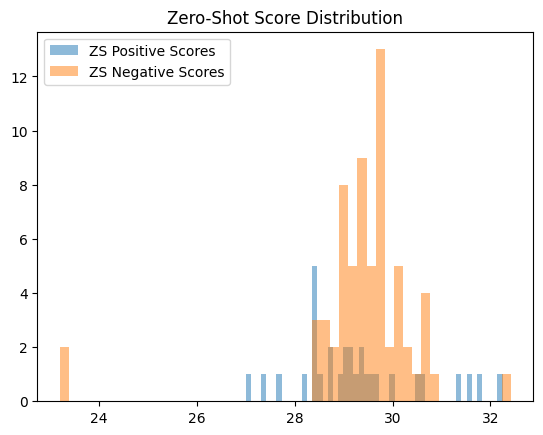

Searching for optimal threshold in range [23.1979 - 32.4159] with 100 steps...


Optimal threshold found: 23.2910 with F1: 0.4839
Zero-Shot CLIP Optimal Validation Metrics (Frame-Level):
  Optimal Threshold: 23.2910
  Precision: 0.3191, Recall: 1.0000, F1-Score: 0.4839, Accuracy: 0.3333
  TN: 2, FP: 64, FN: 0, TP: 30

--- Evaluating Fine-Tuned HL-CLIP Performance ---


Validating FT Model: 100%|██████████| 2/2 [00:49<00:00, 24.96s/it]


Fine-Tuned: Received 96 scores and 96 labels for threshold optimization.


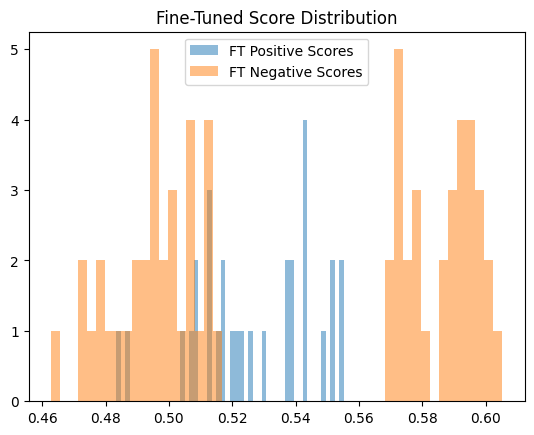

Searching for optimal threshold in range [0.4628 - 0.6052] with 100 steps...


Optimal threshold found: 0.5049 with F1: 0.5455
Fine-Tuned HL-CLIP Optimal Validation Metrics (Frame-Level):
  Optimal Threshold: 0.5049
  Precision: 0.3913, Recall: 0.9000, F1-Score: 0.5455, Accuracy: 0.5312
  TN: 24, FP: 42, FN: 3, TP: 27

Comparison Complete.


In [ ]:
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
dummy_criterion = torch.nn.BCELoss() # For validate_model loss calculation (not used for best threshold)

# --- 4. Validate Zero-Shot CLIP & Find Optimal Threshold ---
print("\n--- Evaluating Zero-Shot CLIP Performance ---")
if validation_loader and len(validation_loader) > 0:
    _, zs_all_scores, zs_all_labels = validate_zero_shot_clip(
        original_clip_model_zs, validation_loader, ZERO_SHOT_PROMPTS, device
    )
    if len(zs_all_scores) > 0 and len(zs_all_labels) > 0:
        print(f"Zero-Shot: Received {len(zs_all_scores)} scores and {len(zs_all_labels)} labels for threshold optimization.")
        # Plot score distribution (optional but recommended for debugging)
        import matplotlib.pyplot as plt
        plt.hist(zs_all_scores[zs_all_labels==1], bins=50, alpha=0.5, label='ZS Positive Scores')
        plt.hist(zs_all_scores[zs_all_labels==0], bins=50, alpha=0.5, label='ZS Negative Scores')
        plt.legend()
        plt.title("Zero-Shot Score Distribution")
        plt.show()

        zs_optimal_metrics = find_optimal_threshold_and_metrics(zs_all_labels, zs_all_scores)
        print("Zero-Shot CLIP Optimal Validation Metrics (Frame-Level):")
        print(f"  Optimal Threshold: {zs_optimal_metrics['threshold']:.4f}")
        print(f"  Precision: {zs_optimal_metrics['precision']:.4f}, Recall: {zs_optimal_metrics['recall']:.4f}, F1-Score: {zs_optimal_metrics['f1']:.4f}, Accuracy: {zs_optimal_metrics['accuracy']:.4f}")
        print(f"  TN: {zs_optimal_metrics['tn']}, FP: {zs_optimal_metrics['fp']}, FN: {zs_optimal_metrics['fn']}, TP: {zs_optimal_metrics['tp']}")
    else:
        print("Zero-Shot: No scores returned from validation to find optimal threshold.")
else:
    print("Skipping Zero-Shot validation.")

# --- 5. Validate Fine-Tuned HL-CLIP Model & Find Optimal Threshold ---
print("\n--- Evaluating Fine-Tuned HL-CLIP Performance ---")
if validation_loader and len(validation_loader) > 0:
    _, ft_all_scores, ft_all_labels = validate_model(
        fine_tuned_model, validation_loader, dummy_criterion, device
    )
    if len(ft_all_scores) > 0 and len(ft_all_labels) > 0:
        print(f"Fine-Tuned: Received {len(ft_all_scores)} scores and {len(ft_all_labels)} labels for threshold optimization.")
        # Plot score distribution (optional)
        import matplotlib.pyplot as plt
        plt.hist(ft_all_scores[ft_all_labels==1], bins=50, alpha=0.5, label='FT Positive Scores')
        plt.hist(ft_all_scores[ft_all_labels==0], bins=50, alpha=0.5, label='FT Negative Scores')
        plt.legend()
        plt.title("Fine-Tuned Score Distribution")
        plt.show()

        ft_optimal_metrics = find_optimal_threshold_and_metrics(ft_all_labels, ft_all_scores)
        print("Fine-Tuned HL-CLIP Optimal Validation Metrics (Frame-Level):")
        print(f"  Optimal Threshold: {ft_optimal_metrics['threshold']:.4f}")
        print(f"  Precision: {ft_optimal_metrics['precision']:.4f}, Recall: {ft_optimal_metrics['recall']:.4f}, F1-Score: {ft_optimal_metrics['f1']:.4f}, Accuracy: {ft_optimal_metrics['accuracy']:.4f}")
        print(f"  TN: {ft_optimal_metrics['tn']}, FP: {ft_optimal_metrics['fp']}, FN: {ft_optimal_metrics['fn']}, TP: {ft_optimal_metrics['tp']}")
    else:
        print("Fine-Tuned: No scores returned from validation to find optimal threshold.")
else:
    print("Skipping Fine-Tuned validation.")

print("\nComparison Complete.")

# Pruning

In [24]:
fine_tuned_model = HLCLIPModel(visual_encoder_component, num_transformer_layers_to_unfreeze=2).to(device)
fine_tuned_model.load_state_dict(torch.load("best_hlclip_model.pth", weights_only=True))
fine_tuned_model.eval()

HLCLIPModel(
  (clip_visual_encoder): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, b

In [25]:
import torch.nn.utils.prune as prune

# Apply to specific layers of your fine_tuned_model or its components
# Example: Pruning the first linear layer of the model's FC head (if `model.fc` is the head)
model_to_prune = fine_tuned_model # or specific parts
if hasattr(model_to_prune, 'fc') and isinstance(model_to_prune.fc, torch.nn.Linear):
    prune.random_unstructured(model_to_prune.fc, name="weight", amount=0.3) # Prune 30% of weights
    prune.remove(model_to_prune.fc, 'weight') # Make pruning permanent
    print("Pruned model.fc layer.")

# More generally, to prune multiple layers:
parameters_to_prune = []
for name, module in fine_tuned_model.named_modules():
    if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
        parameters_to_prune.append((module, 'weight'))

if parameters_to_prune:
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured, # or RandomUnstructured
        amount=0.2  # Prune 20% of total weights across these layers
    )
    # To make it permanent and remove reparameterization:
    for module, name in parameters_to_prune:
        prune.remove(module, name)
    print(f"Globally pruned {len(parameters_to_prune)} layers.")

# IMPORTANT: After pruning, you usually need to fine-tune the model for some epochs
# to recover accuracy.

Pruned model.fc layer.
Globally pruned 39 layers.


In [26]:
# (Your existing training setup: model, optimizer, criterion, train_loader, etc.)
# ... (HLCLIPModel, ElephantHighlightDataset, collate_fn, preprocess, device etc. need to be defined)
# ... (Load CLIP, convert to float32, instantiate HLCLIPModel, optimizer, criterion as before)
# ... (Create dummy train/val videos, train_dataset, train_loader, validation_dataset, validation_loader as shown above)

model = fine_tuned_model

# Optimizer and Loss
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
criterion = torch.nn.BCELoss()


print("Starting training and validation loop...")
num_epochs = 4 # Example
best_val_f1 = -1 # To save the best model based on F1-score, for example

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    total_train_loss = 0
    train_batches_processed = 0

    for batch_idx, batch_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")):
        # ... (your existing training batch logic) ...
        if batch_data is None or batch_data[0] is None:
            print(f"Skipping empty or invalid training batch {batch_idx} from collate_fn.")
            continue
        video_frames, labels = batch_data
        if video_frames.nelement() == 0:
            print(f"Skipping training batch {batch_idx} due to empty video_frames tensor.")
            continue

        video_frames = video_frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(video_frames)

        min_len = min(predictions.shape[1], labels.shape[1])
        if min_len == 0:
            print(f"Skipping training batch {batch_idx} due to min_len=0.")
            continue
        predictions_aligned = predictions[:, :min_len]
        labels_aligned = labels[:, :min_len]

        if predictions_aligned.nelement() == 0 or labels_aligned.nelement() == 0:
            print(f"Skipping training batch {batch_idx} due to zero elements post-alignment.")
            continue

        try:
            loss = criterion(predictions_aligned, labels_aligned)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            train_batches_processed +=1
        except RuntimeError as e:
            print(f"Runtime error during training loss/backward for batch {batch_idx}: {e}")
            continue

    avg_train_loss = total_train_loss / train_batches_processed if train_batches_processed > 0 else 0
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

    # --- Validation Step ---
    if validation_loader: # Only run validation if the loader was successfully created
        avg_val_loss, val_metrics = validate_model(model, validation_loader, criterion, device, threshold=0.5)
        print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")
        print(f"Epoch {epoch+1} - Validation Metrics (Frame-Level):")
        print(f"  Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, F1-Score: {val_metrics['f1']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"  TN: {val_metrics['tn']}, FP: {val_metrics['fp']}, FN: {val_metrics['fn']}, TP: {val_metrics['tp']}")

        # Example: Save the model if validation F1 improves
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            torch.save(model.state_dict(), "best_prune_hlclip_model.pth")
            print(f"New best validation F1: {best_val_f1:.4f}. Model saved to best_prune_hlclip_model.pth")
    else:
        print("Skipping validation as validation_loader is not available.")

print("Training and validation finished.")

Starting training and validation loop...


Epoch 1/4 [Training]: 100%|██████████| 10/10 [04:07<00:00, 24.70s/it]


Epoch 1 - Training Loss: 0.5819


Validating: 100%|██████████| 2/2 [00:50<00:00, 25.21s/it]


Epoch 1 - Validation Loss: 0.7515
Epoch 1 - Validation Metrics (Frame-Level):
  Precision: 0.4407, Recall: 0.8667, F1-Score: 0.5843, Accuracy: 0.6146
  TN: 33, FP: 33, FN: 4, TP: 26
New best validation F1: 0.5843. Model saved to best_prune_hlclip_model.pth


Epoch 2/4 [Training]: 100%|██████████| 10/10 [03:49<00:00, 22.96s/it]


Epoch 2 - Training Loss: 0.4756


Validating: 100%|██████████| 2/2 [00:47<00:00, 23.79s/it]


Epoch 2 - Validation Loss: 0.8041
Epoch 2 - Validation Metrics (Frame-Level):
  Precision: 0.4426, Recall: 0.9000, F1-Score: 0.5934, Accuracy: 0.6146
  TN: 32, FP: 34, FN: 3, TP: 27
New best validation F1: 0.5934. Model saved to best_prune_hlclip_model.pth


Epoch 3/4 [Training]: 100%|██████████| 10/10 [03:49<00:00, 22.95s/it]


Epoch 3 - Training Loss: 0.3979


Validating: 100%|██████████| 2/2 [00:46<00:00, 23.17s/it]


Epoch 3 - Validation Loss: 0.8768
Epoch 3 - Validation Metrics (Frame-Level):
  Precision: 0.4265, Recall: 0.9667, F1-Score: 0.5918, Accuracy: 0.5833
  TN: 27, FP: 39, FN: 1, TP: 29


Epoch 4/4 [Training]: 100%|██████████| 10/10 [03:47<00:00, 22.79s/it]


Epoch 4 - Training Loss: 0.3263


Validating: 100%|██████████| 2/2 [00:48<00:00, 24.01s/it]


Epoch 4 - Validation Loss: 0.8930
Epoch 4 - Validation Metrics (Frame-Level):
  Precision: 0.4500, Recall: 0.9000, F1-Score: 0.6000, Accuracy: 0.6250
  TN: 33, FP: 33, FN: 3, TP: 27
New best validation F1: 0.6000. Model saved to best_prune_hlclip_model.pth
Training and validation finished.


# Zero-shot VS Pruned Fine-Tuning

In [35]:
prune_fine_tuned_model = HLCLIPModel(visual_encoder_component, num_transformer_layers_to_unfreeze=2).to(device)
prune_fine_tuned_model.load_state_dict(torch.load("best_prune_hlclip_model.pth", weights_only=True))
prune_fine_tuned_model.eval()

HLCLIPModel(
  (clip_visual_encoder): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, b

In [42]:
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
dummy_criterion = torch.nn.BCELoss() # For validate_model loss calculation (not used for best threshold)

# --- 4. Validate Zero-Shot CLIP & Find Optimal Threshold ---
print("\n--- Evaluating Zero-Shot CLIP Performance ---")
if validation_loader and len(validation_loader) > 0:
    _, zs_all_scores, zs_all_labels = validate_zero_shot_clip(
        original_clip_model_zs, validation_loader, ZERO_SHOT_PROMPTS, device
    )
    if len(zs_all_scores) > 0 and len(zs_all_labels) > 0:
        print(f"Zero-Shot: Received {len(zs_all_scores)} scores and {len(zs_all_labels)} labels for threshold optimization.")
        # Plot score distribution (optional but recommended for debugging)
        # import matplotlib.pyplot as plt
        # plt.hist(zs_all_scores[zs_all_labels==1], bins=50, alpha=0.5, label='ZS Positive Scores')
        # plt.hist(zs_all_scores[zs_all_labels==0], bins=50, alpha=0.5, label='ZS Negative Scores')
        # plt.legend()
        # plt.title("Zero-Shot Score Distribution")
        # plt.show()

        zs_optimal_metrics = find_optimal_threshold_and_metrics(zs_all_labels, zs_all_scores)
        print("Zero-Shot CLIP Optimal Validation Metrics (Frame-Level):")
        print(f"  Optimal Threshold: {zs_optimal_metrics['threshold']:.4f}")
        print(f"  Precision: {zs_optimal_metrics['precision']:.4f}, Recall: {zs_optimal_metrics['recall']:.4f}, F1-Score: {zs_optimal_metrics['f1']:.4f}, Accuracy: {zs_optimal_metrics['accuracy']:.4f}")
        print(f"  TN: {zs_optimal_metrics['tn']}, FP: {zs_optimal_metrics['fp']}, FN: {zs_optimal_metrics['fn']}, TP: {zs_optimal_metrics['tp']}")
    else:
        print("Zero-Shot: No scores returned from validation to find optimal threshold.")
else:
    print("Skipping Zero-Shot validation.")

# --- 5. Validate. Pruned Fine-Tuned HL-CLIP Model & Find Optimal Threshold ---
print("\n--- Evaluating Pruned Fine-Tuned HL-CLIP Performance ---")
if validation_loader and len(validation_loader) > 0:
    _, ft_all_scores, ft_all_labels = validate_model(
        prune_fine_tuned_model, validation_loader, dummy_criterion, device
    )
    if len(ft_all_scores) > 0 and len(ft_all_labels) > 0:
        print(f"Pruned Fine-Tuned: Received {len(ft_all_scores)} scores and {len(ft_all_labels)} labels for threshold optimization.")
        # Plot score distribution (optional)
        # import matplotlib.pyplot as plt
        # plt.hist(ft_all_scores[ft_all_labels==1], bins=50, alpha=0.5, label='FT Positive Scores')
        # plt.hist(ft_all_scores[ft_all_labels==0], bins=50, alpha=0.5, label='FT Negative Scores')
        # plt.legend()
        # plt.title("Fine-Tuned Score Distribution")
        # plt.show()

        ft_optimal_metrics = find_optimal_threshold_and_metrics(ft_all_labels, ft_all_scores)
        print("Pruned Fine-Tuned HL-CLIP Optimal Validation Metrics (Frame-Level):")
        print(f"  Optimal Threshold: {ft_optimal_metrics['threshold']:.4f}")
        print(f"  Precision: {ft_optimal_metrics['precision']:.4f}, Recall: {ft_optimal_metrics['recall']:.4f}, F1-Score: {ft_optimal_metrics['f1']:.4f}, Accuracy: {ft_optimal_metrics['accuracy']:.4f}")
        print(f"  TN: {ft_optimal_metrics['tn']}, FP: {ft_optimal_metrics['fp']}, FN: {ft_optimal_metrics['fn']}, TP: {ft_optimal_metrics['tp']}")
    else:
        print("Pruned Fine-Tuned: No scores returned from validation to find optimal threshold.")
else:
    print("Skipping Pruned Fine-Tuned validation.")

print("\nComparison Complete.")


--- Evaluating Zero-Shot CLIP Performance ---


Validating Zero-Shot CLIP: 100%|██████████| 2/2 [00:48<00:00, 24.06s/it]


Zero-Shot: Received 96 scores and 96 labels for threshold optimization.
Searching for optimal threshold in range [23.1979 - 32.4159] with 100 steps...


Optimal threshold found: 23.2910 with F1: 0.4839
Zero-Shot CLIP Optimal Validation Metrics (Frame-Level):
  Optimal Threshold: 23.2910
  Precision: 0.3191, Recall: 1.0000, F1-Score: 0.4839, Accuracy: 0.3333
  TN: 2, FP: 64, FN: 0, TP: 30

--- Evaluating Pruned Fine-Tuned HL-CLIP Performance ---


Validating FT Model: 100%|██████████| 2/2 [00:46<00:00, 23.41s/it]


Pruned Fine-Tuned: Received 96 scores and 96 labels for threshold optimization.
Searching for optimal threshold in range [0.3126 - 0.7610] with 100 steps...


Optimal threshold found: 0.4951 with F1: 0.6154
Pruned Fine-Tuned HL-CLIP Optimal Validation Metrics (Frame-Level):
  Optimal Threshold: 0.4951
  Precision: 0.4590, Recall: 0.9333, F1-Score: 0.6154, Accuracy: 0.6354
  TN: 33, FP: 33, FN: 2, TP: 28

Comparison Complete.


# PyTorch JIT Compilation (TorchScript)

In [ ]:
prune_fine_tuned_model = HLCLIPModel(visual_encoder_component, num_transformer_layers_to_unfreeze=2).to(device)
prune_fine_tuned_model.load_state_dict(torch.load("best_prune_hlclip_model.pth", weights_only=True))
prune_fine_tuned_model.eval()

In [43]:
# --- 3. (Optional but Recommended) Convert to TorchScript ---
try:
    # Example input for tracing (adjust shape and dtype)
    example_input_shape = (1, 32, 3, 224, 224) # (B, N_frames, C, H, W)
    # Ensure dtype matches what your model expects after preprocess (usually float32)
    # and device matches the model's device
    example_input_val = torch.randn(example_input_shape, dtype=torch.float32).to(device)
    traced_model = torch.jit.trace(prune_fine_tuned_model, example_input_val)
    print("Model traced to TorchScript.")
except Exception as e:
    print(f"Error tracing model: {e}. Proceeding with original model (might be less optimal for TensorRT).")
    traced_model = prune_fine_tuned_model

Model traced to TorchScript.


In [46]:
highlights = predict_highlights(val_video_paths[0], traced_model, preprocess, device)
print(f"Detected highlights in {val_video_paths[0]}: {highlights}")

Detected highlights in /content/drive/MyDrive/elephant_clip/val/good/Copy of 3QbFg0aff2Q.webm: [(0.0, 1.6693376068376067), (2.003205128205128, 2.003205128205128), (2.6709401709401708, 11.351495726495726), (11.685363247863247, 13.354700854700853), (13.855502136752136, 14.022435897435896), (14.356303418803417, 14.523237179487179)]


# Quantization

In [48]:
import torch
import torch_tensorrt # This import will only work after successful installation
from tqdm import tqdm

# (Assuming fine_tuned_model, traced_model, device, example_input_val are set up)
try:
    print("Starting Torch-TensorRT compilation for FP16...")
    trt_model_fp16 = torch_tensorrt.compile(
        traced_model, # Or fine_tuned_model
        inputs=[torch_tensorrt.Input(
            min_shape=example_input_shape,
            opt_shape=example_input_shape,
            max_shape=example_input_shape,
            dtype=torch.float32 # Input to the TRT engine is still FP32, then converted
        )],
        enabled_precisions={torch.float16}, # Key change for FP16
        workspace_size=1 << 30 # 1GB
    )
    print("Model successfully compiled with Torch-TensorRT to FP16.")
    # torch.jit.save(trt_model_fp16, "trt_hlclip_fp16.ts")
    # Test inference
    # output_fp16 = trt_model_fp16(example_input_val)
    # print("Output from FP16 TensorRT model:", output_fp16.shape)
except Exception as e:
    print(f"Error during Torch-TensorRT FP16 compilation: {e}")

ModuleNotFoundError: No module named 'torch_tensorrt'